# Epidemic modeling using various fully-mixed compartmental models such as the SIR, SIS and SIRS models in Julia

#### These are traditional models that assumes a fully mixed population and therefore of lower fidelity compared to more modern techniques. However, it should help to give a general understanding of how diseases spread.

#### Ref: "Networks" by Mark Newman, Print ISBN-13: 9780198805090

@copyright Dr. Srijith Rajamohan under the Creative Commons Attribution license CC BY 4.0
(Rights given to reproduce this as desired under the license agreement listed)

In [ ]:
using Pkg

In [2]:
Pkg.add("DifferentialEquations")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %=======>                                 ]  17.3 %34.4 %=====================>                   ]  51.6 %68.8 %===================================>     ]  86.0 % Resolving package versions...
 Installed ConsoleProgressMonitor ───── v0.1.2
 Installed FunctionWrappers ─────────── v1.1.1
 Installed DifferentialEquations ────── v6.10.1
 Installed DiffEqNoiseProcess ───────── v3.9.0
 Installed ChainRulesCore ───────────── v0.7.1
 Installed DelayDiffEq ──────────────── v5.23.0
 Installed Sundials ─────────────────── v3.8.3
 Installed DiffEqBase ───────────────── v6.20.0
 Installed TerminalLoggers ──────────── v0.1.1
 Installed LeftChildRightSiblingTrees ─ v0.1.2
 Installed ResettableStacks ─────────── v1.0.0
 Installed DiffEqPhysics ────────────── v3.5.0
 Installed DimensionalPlotRecipes ───── v1.1.0
 Inst

In [7]:
Pkg.add("Plots")

 Resolving package versions...
 Installed Showoff ─────── v0.3.1
 Installed PlotThemes ──── v1.0.1
 Installed Plots ───────── v0.29.8
 Installed FFMPEG ──────── v0.2.4
 Installed GeometryTypes ─ v0.8.1
 Installed PlotUtils ───── v0.6.4
 Installed Contour ─────── v0.5.2
 Installed Measures ────── v0.3.1
 Installed GR ──────────── v0.48.0
  Updating `~/.julia/environments/v1.0/Project.toml`
  [91a5bcdd] + Plots v0.29.8
  Updating `~/.julia/environments/v1.0/Manifest.toml`
  [d38c429a] + Contour v0.5.2
  [c87230d0] + FFMPEG v0.2.4
  [28b8d3ca] + GR v0.48.0
  [4d00f742] + GeometryTypes v0.8.1
  [442fdcdd] + Measures v0.3.1
  [ccf2f8ad] + PlotThemes v1.0.1
  [995b91a9] + PlotUtils v0.6.4
  [91a5bcdd] + Plots v0.29.8
  [992d4aef] + Showoff v0.3.1
  Building GR ────→ `~/.julia/packages/GR/yMV3y/deps/build.log`
  Building FFMPEG → `~/.julia/packages/FFMPEG/guN1x/deps/build.log`
  Building Plots ─→ `~/.julia/packages/Plots/vTdnV/deps/build.log`


In [147]:
Pkg.installed()

Dict{String,Union{Nothing, VersionNumber}} with 11 entries:
  "CSV"                   => v"0.5.26"
  "Optim"                 => v"0.20.4"
  "HTTP"                  => v"0.8.12"
  "Metalhead"             => v"0.5.0"
  "Images"                => v"0.22.0"
  "IJulia"                => v"1.21.1"
  "Flux"                  => v"0.10.3"
  "Plots"                 => v"0.29.8"
  "DifferentialEquations" => v"6.10.1"
  "DataFrames"            => v"0.20.2"
  "ArrayFire"             => v"1.0.6"

In [2]:
using DifferentialEquations
using Plots

## The following applies to the models below

#### s corresponds to the percentage of susceptible people in the population
#### x corresponds to the percentage of infected people in the population
#### r corresponds to the percentage of recovered people in the population
#### beta measures the average number of contacts a person has in unit time ( implications for social distancing )
#### gamma corresponds to the rate at which individuals recover or die, i.e. the fraction of recovery one experiences in unit time 
#### R0 is the the basic reproduction number that represents the average number of people that an infected person 'A' infects at the beginning of the epidemic, before the person 'A' recovers. ( Thi is different from r0 which is the initial condition for r in the equations below)

#### R0 = beta / gamma

## Using the SIR model

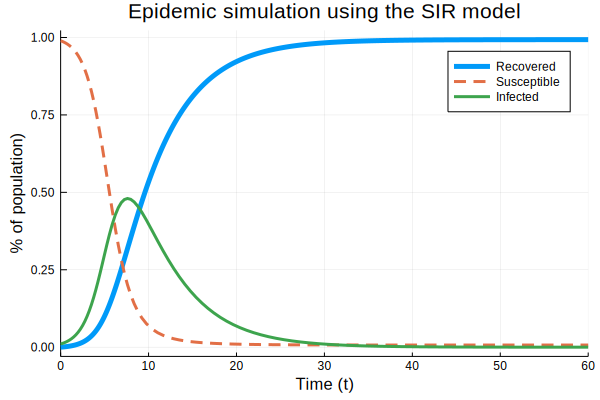

In [259]:
function sir(;s0,  beta, gamma, r0, title="Epidemic simulation using the SIR model")
    f(r,p,t) = gamma * (1 - r - s0 * exp(-beta * r / gamma))

    tspan = (0.0,60.0)
    prob = ODEProblem(f,r0,tspan)
    r = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)   # Fifth order Tsitouras method
    s = s0 * exp.( -beta .* r ./ gamma)
    x = 1 .- s .- r

    plot(r,linewidth=5,title=title,
         xaxis="Time (t)",yaxis="% of population)",label="Recovered") # legend=false
    plot!(r.t, s,lw=3,ls=:dash,label="Susceptible")
    plot!(r.t, x,lw=3,label="Infected")
end

sir(s0 = 0.99, beta = 1.0, gamma = 0.2, r0 = 0.0001)

## Using the SIS model

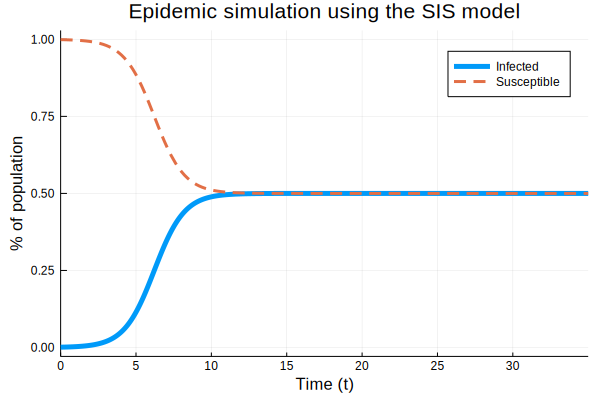

In [144]:
function sis(;x0,  beta)
    f(x,p,t) = (beta - x - beta * x) * x

    tspan = (0.0,35.0)
    prob = ODEProblem(f,x0,tspan)
    x = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)   # Fifth order Tsitouras method
    
    plot(x,linewidth=5,title="Epidemic simulation using the SIS model",
         xaxis="Time (t)",yaxis="% of population",label="Infected") # legend=false
    plot!(x.t,  1 .- x,lw=3,ls=:dash,label="Susceptible")
    
end

sis(x0 = 0.001, beta = 1.0)

## Using the SIRS model

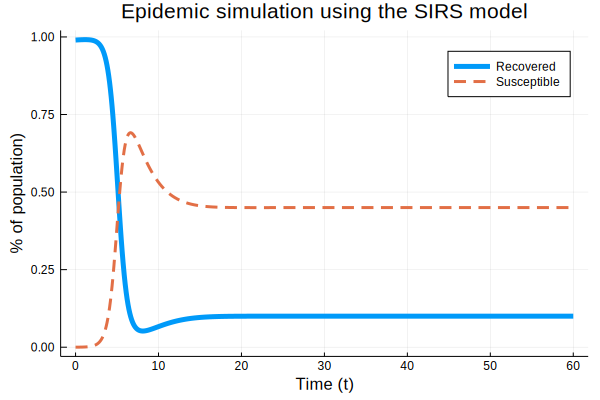

In [216]:
function sirs(; beta, gamma, delta)
    function f!(du,u,p,t)
        du[1] = gamma * (1 - u[1] - u[2]) - beta * u[1] * u[2]
        du[2] = beta * u[1] * u[2] - gamma * u[2]
    end

    u0 = [0.99; 0.0001]
    tspan = (0.0,60.0)
    prob = ODEProblem(f!,u0,tspan)
    u = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)   # Fifth order Tsitouras method
    u0 = [ elem[1] for elem in u.u]
    u1 = [ elem[2] for elem in u.u]

    plot(u.t, u0,linewidth=5,title="Epidemic simulation using the SIRS model",
         xaxis="Time (t)",yaxis="% of population)",label="Recovered") # legend=false
    plot!(u.t, u1,lw=3,ls=:dash,label="Susceptible")
end

sirs( beta = 2.0, gamma = 0.2, delta = 0.1)

In [100]:
# Setup colormap
C(g::ColorGradient) = RGB[g[z] for z=linspace(0,1,30)]
g = :amp
cgrad(g)[0]

## The influence of social distancing on the total infection rate as shown by the changing the parameter beta using the SIR model

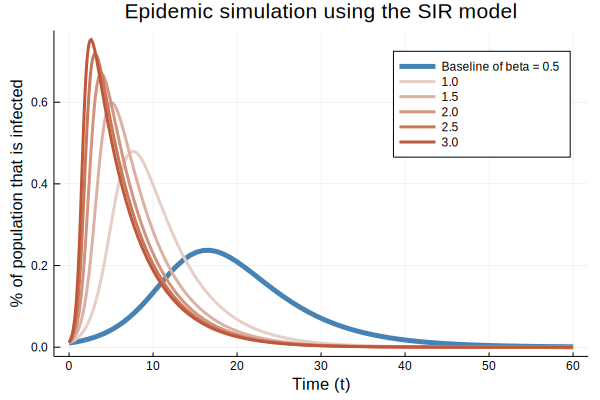

In [214]:
gamma_val = 0.2
r0_val = 0.0001

function sir(;s0,  beta, gamma, r0)
    f(r,p,t) = gamma * (1 - r - s0 * exp(-beta * r / gamma))

    tspan = (0.0,60.0)
    prob = ODEProblem(f,r0,tspan)
    r = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)   # Fifth order Tsitouras method
    s = s0 * exp.( -beta .* r ./ gamma)
    x = 1 .- s .- r
    return(x, r.t)
    
end

x,t = sir(s0 = 0.99, beta = 0.5, gamma = gamma_val, r0 = r0_val)
plot(t, x,linewidth=5,title="Epidemic simulation using the SIR model", linecolor="steelblue",
         xaxis="Time (t)",yaxis="% of population that is infected",label="Baseline of beta = 0.5") # legend=false

count = 0.1
for i in 1.0: 0.5 :3.0
    x,t = sir(s0 = 0.99, beta = i, gamma = gamma_val, r0 = r0_val)
    #print(t)
    a = plot!(t, x,lw=3,label=i, linecolor=cgrad(g)[count]) # legend=false
    count += 0.1
end
display(a)

#### Beta is a measure of how many people a sick person can infect, with social distancing this number decreases. For e.g with beta going from 3.0 to 0.5 the total percentage of the population that is infected reduces from 80% to 20%.

## Simulation using the SIR model for the Coronavirus and the Flu from estimated parameters (These numbers most certainly need to be updated!)

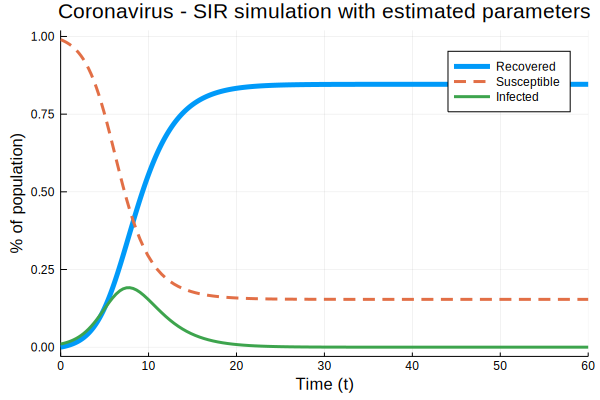

In [264]:
# Estimates for gamma and beta for COVID obtained from https://arxiv.org/pdf/2002.06563.pdf
# Epidemic analysis of COVID-19 in China by dynamical modeling
# Liangrong Peng, Wuyue Yang, Dongyan Zhang, Changjing Zhuge, Liu Hong
# medRxiv 2020.02.16.20023465; doi: https://doi.org/10.1101/2020.02.16.20023465
# Estimate for gamma for flu was not available

beta_val(;R0, gamma) = R0 * gamma
cv = beta_val(R0 = 2.2, gamma = 0.5) 
fl = beta_val(R0 = 1.3, gamma = 0.5)

sir(s0 = 0.99, beta = cv, gamma = 0.5, r0 = 0.0001, title="Coronavirus - SIR simulation with estimated parameters")

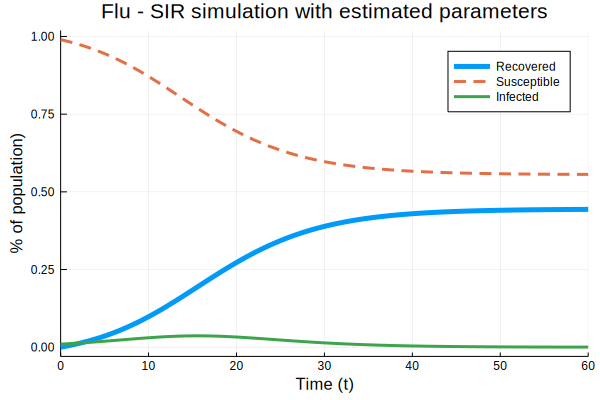

In [263]:
sir(s0 = 0.99, beta = fl, gamma = 0.5, r0 = 0.0001, title="Flu - SIR simulation with estimated parameters")

## Size of the outbreak (S) as a percentage of the population vs. transmission probability of the disease(phi)

#### The size of the outbreak (S) as a percentage of the population vs. transmission probability (function of the transmission rate) of the disease(phi). The mean degree (c) of the network is the average number of connections a person has. This is modelled for a disease modeled as a SIR assuming a Poisson random network model and 'c' corresponds to the mean degree of the network. 

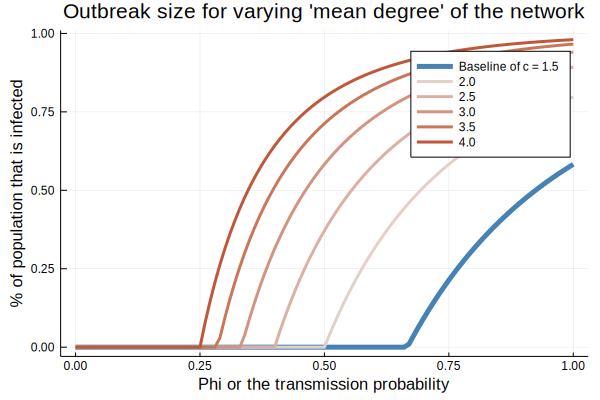

In [211]:
using Optim

# c is the mean degree of the random network
c_baseline = 1.5
c_end = 4.0

# Newton's solve 
function solve_S(;c,phi)
    f(S) = 1 - exp(-phi*c*S) - S# Function
    df(S) = c * phi * exp(-phi * c * S) - 1

    S_iter = 0.5
    for i in 1 : 300
        delS = -f(S_iter) / df(S_iter)
        S_iter += delS 
    end
    
    return(S_iter)
end

r = [ solve_S(c = c_baseline, phi = i) for i in 0:0.01:1]
plot([0: 0.01: 1], r,linewidth=5,title="Outbreak size for varying 'mean degree' of the network", linecolor="steelblue",
         xaxis="Phi or the transmission probability",yaxis="% of population that is infected",label="Baseline of c = 1.5") # legend=false

count = 0.1
for c in c_baseline + 0.5: 0.5: c_end
    r = [ solve_S(c = c, phi = i) for i in 0 : 0.01 : 1]
    a = plot!([0: 0.01: 1], r, lw=3, label=c, linecolor=cgrad(g)[count]) # legend=false
    count += 0.1
end
display(a)

#### Diseases tend to have a certain transmission and disease 'A' may have a higher transmission probability (e.g. 0.55) compared to disease 'B' (e.g. 0.75). If we pick a curve corresponding to our network structure, let's say c = 2.0, we can see that drawing a line up to this curve 'c = 2.0' intersects it at around 20% for A and around 70% for B. As the degree of the network or the connectedness of the network increases, we can see that both diseases tend to infect a larger percentage of the population.
